In [2]:
import os
from pathlib import Path
import json
import glob
import shutil
import numpy as np
from IPython import display
from IPython.display import clear_output
import yaml
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Check if yolov5 exist in active directory

In [ ]:
if os.path.exists('../yolov5') == False :
    
    %cd ../yolov5 # set yolov5 as active directory
    !git clone https://github.com/ultralytics/yolov5 
    
else :
    %cd ../yolov5

## Create dataset directory and split data

In [16]:
PARENT_PATH = '..\\build_pool_model\\labelled_dataset\\' # should be your yolo labelised dataset

In [17]:
list_png = glob.glob(f'{PARENT_PATH}\images\*')
list_label = glob.glob(f'{PARENT_PATH}labels\*')

In [18]:
def create_data_directories(data_dir):
    
    # Supress dataset directory if exists
    if os.path.exists(f"../datasets/{data_dir}/labels") == True :
        shutil.rmtree(f"../datasets/{data_dir}/labels")
    if os.path.exists(f"../datasets/{data_dir}/images") == True :
        shutil.rmtree(f"../datasets/{data_dir}/images")
        
    Path(f"../datasets/{data_dir}/images/train").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_dir}/images/val").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_dir}/images/test").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_dir}/labels/train").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_dir}/labels/val").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_dir}/labels/test").mkdir(parents=True, exist_ok=True)



In [19]:
def split_data(labelised_dataset, data_dir, train_ratio = 0.85, valid_ratio = 0.10) :
    '''
    
    '''
    list_png = glob.glob(f'{labelised_dataset}\\images\\*') # put '..\' if labelised_dataset is outside yolo directory
    list_label = glob.glob(f'{labelised_dataset}\\labels\\*')
    n_data = len(list_png)
    print(f'total size : {n_data}')
    #images
    train_list_img = list_png[0: int(n_data * train_ratio)]
    val_list_img = list_png[len(train_list_img) : len(train_list_img)+int(n_data * valid_ratio)]
    test_list_img = list_png[len(train_list_img) + len(val_list_img)::]
    #labels
    train_list_lab = list_label[0:int(n_data * train_ratio)]
    val_list_lab = list_label[len(train_list_lab) : len(train_list_lab)+ int(n_data * valid_ratio)]
    test_list_lab = list_label[len(train_list_lab) + len(val_list_lab)::]
    
    
    print(f'train size : {len(train_list_img)}\nvalidation size : {len(val_list_img)}\ntest size :{len(test_list_img)}')
    for train_img, train_lab in zip(train_list_img, train_list_lab) :
        name_png = train_img.split('\\')[-1]
        name_label = train_lab.split('\\')[-1]
        #print(name_png, name_label)
        shutil.copyfile(train_img, f"..\\datasets\\{data_dir}\\images\\train\\{name_png}")
        shutil.copyfile(train_lab, f"..\\datasets\\{data_dir}\\labels\\train\\{name_label}")
    
    print(f'--- Train set : Done ---')
   
    for val_img, val_lab in zip(val_list_img, val_list_lab) :
        name_png = val_img.split('\\')[-1]
        name_label = val_lab.split('\\')[-1]

        shutil.copyfile(val_img, f"..\\datasets\\{data_dir}\\images\\val\\{name_png}")
        shutil.copyfile(val_lab, f"..\\datasets\\{data_dir}\\labels\\val\\{name_label}")
        
    print(f'--- Validation set : Done ---')
    
    for test_img, test_lab in zip(test_list_img, test_list_lab) :
        name_png = test_img.split('\\')[-1]
        name_label = test_lab.split('\\')[-1]

        shutil.copyfile(test_img, f"..\\datasets\\{data_dir}\\images\\test\\{name_png}")
        shutil.copyfile(test_lab, f"..\\datasets\\{data_dir}\\labels\\test\\{name_label}")
        
    print(f'--- Test set : Done ---')
    
        

In [21]:
create_data_directories('Pool_data')
split_data(PARENT_PATH, 'Pool_data')

total size : 746
train size : 634
validation size : 74
test size :38
--- Train set : Done ---
--- Validation set : Done ---
--- Test set : Done ---


### Create dataset.yaml

- https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data#11-create-datasetyaml
- .yaml file must contain path, test and train dataset path and class name

## Train Data

must
- give dataset yaml path
- weights : use default pre-trained yolov5s weights
- project : project name, create new directory with all runs.
- freeze : Freeze the last 12 layers (faster result)
To further compensate for a small dataset size, we’ll use the same backbone as the pretrained COCO model, and only train the model’s head. YOLOv5s6 backbone consists of 12 layers, who will be fixed by the ‘freeze’ argument. à changer !!!!! 

In [ ]:
!python train.py --img 600 --batch 8 --workers 1 --epochs 200 --data data/pool_dataset.yaml --weights yolov5s.pt --project runs_pool --freeze 12


### See last run results

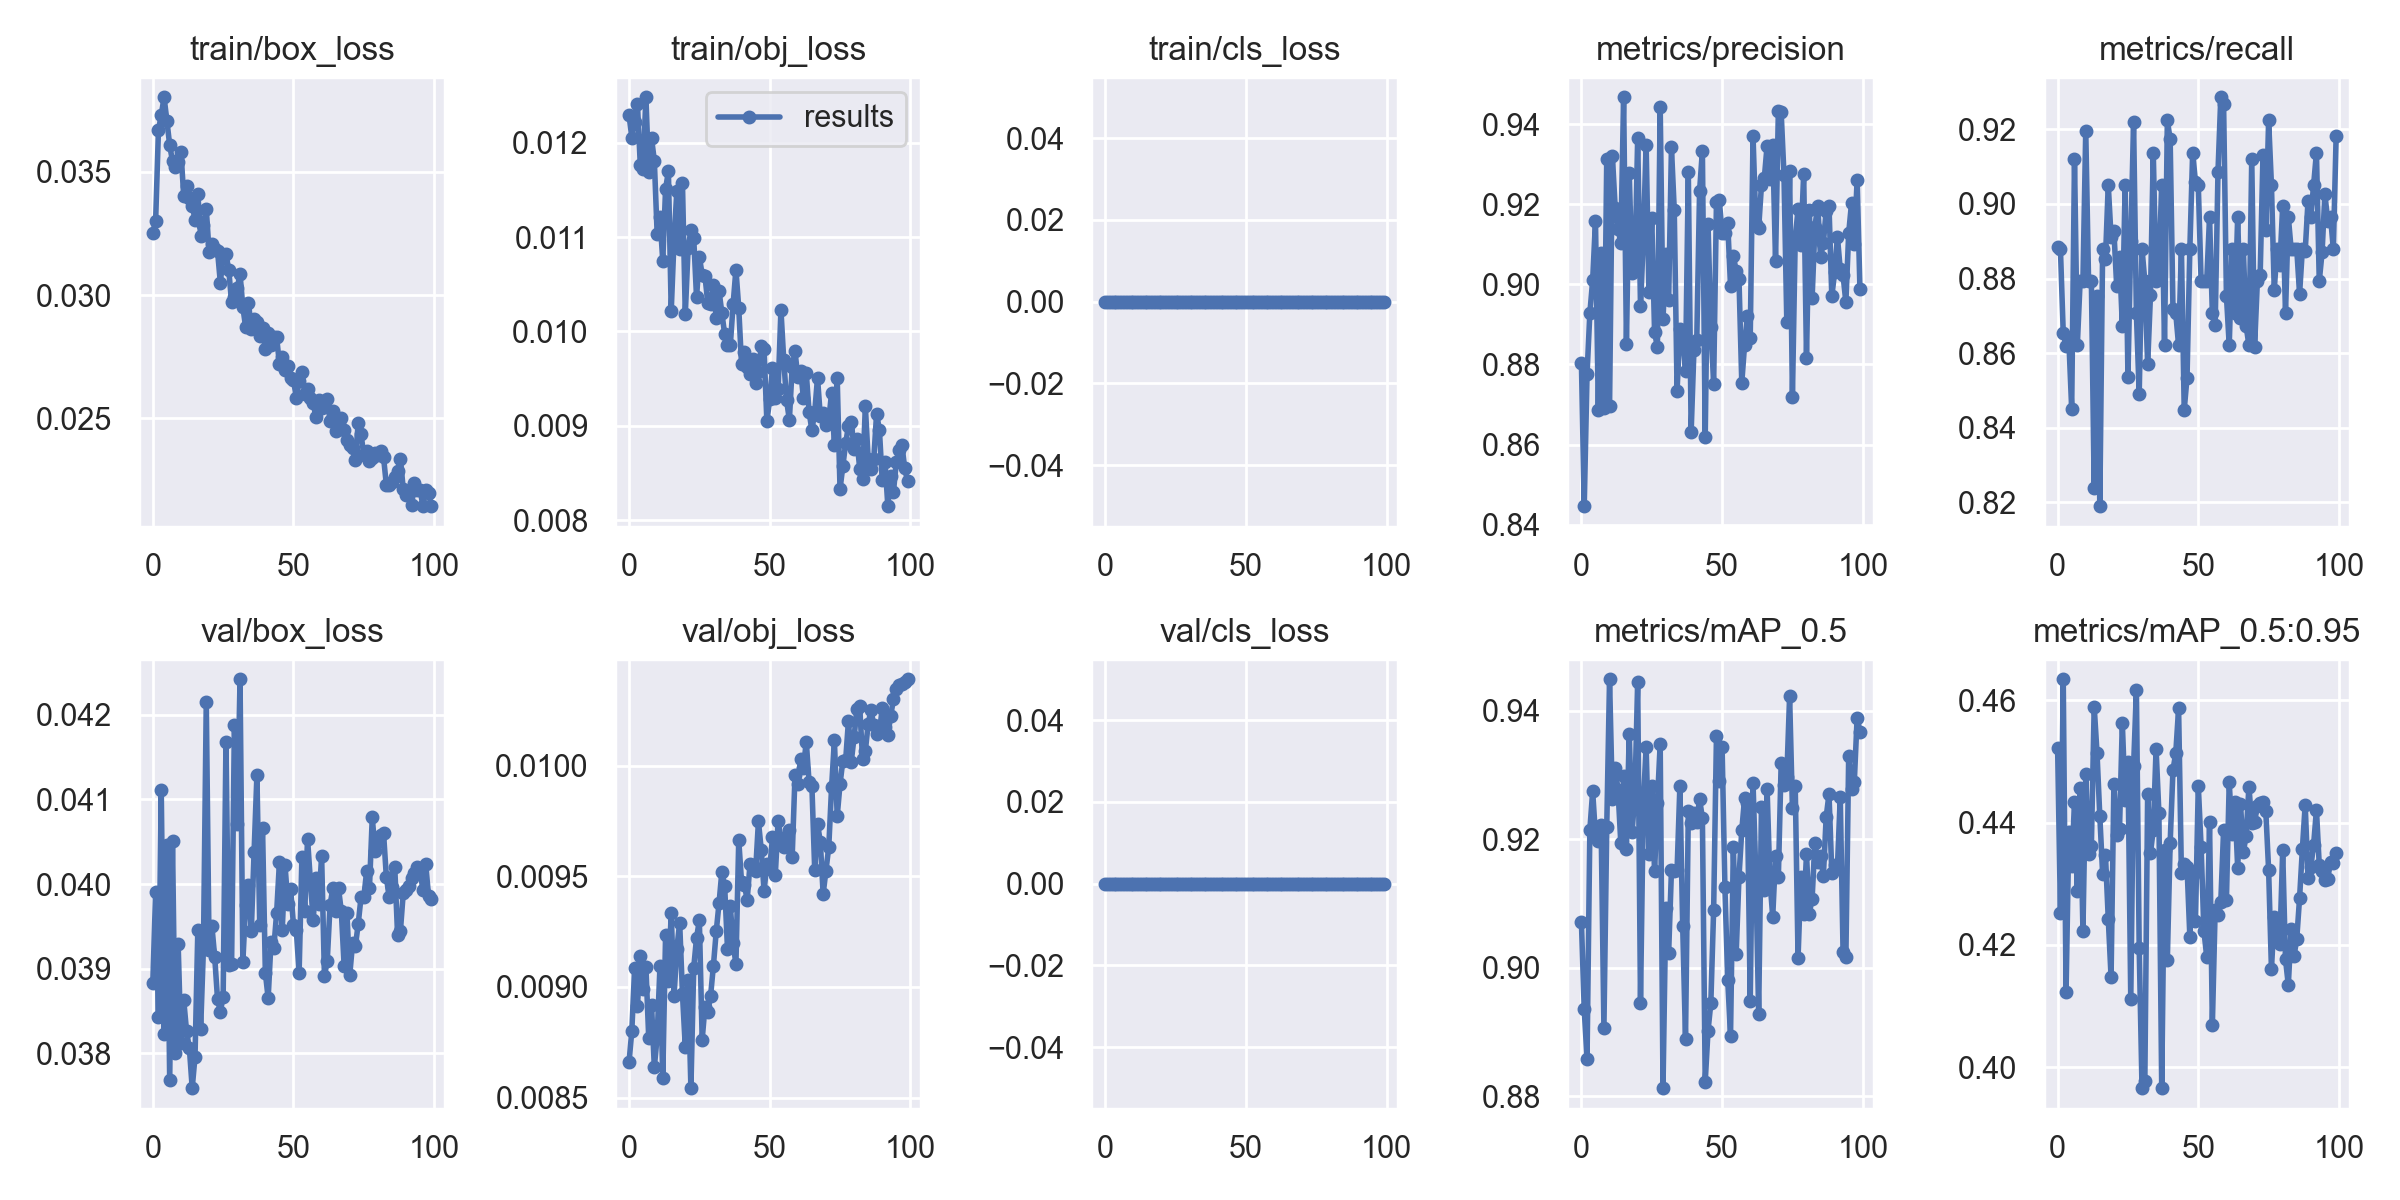

In [4]:
last_run = glob.glob(f"runs_pool/*")[-1]
display.Image(f"{last_run}/results.png")

## Let's Fine tune ! 

We use the 'hyp.yaml' file inside our result folder (runs_pool) to fine tune our model. In order to fine tune our model, we replace the pre-trained weights used with our lastest weight with a very low learning rate. This time we un-freeze the model.

In [ ]:
!python train.py --img 600 --batch 8 --workers 1 --epochs 100 --hyp runs_pool/exp6/hyp.yaml --data data/pool_dataset.yaml --weights runs_pool/exp6/weights/best.pt --project runs_pool --name fine_tune
clear_output()

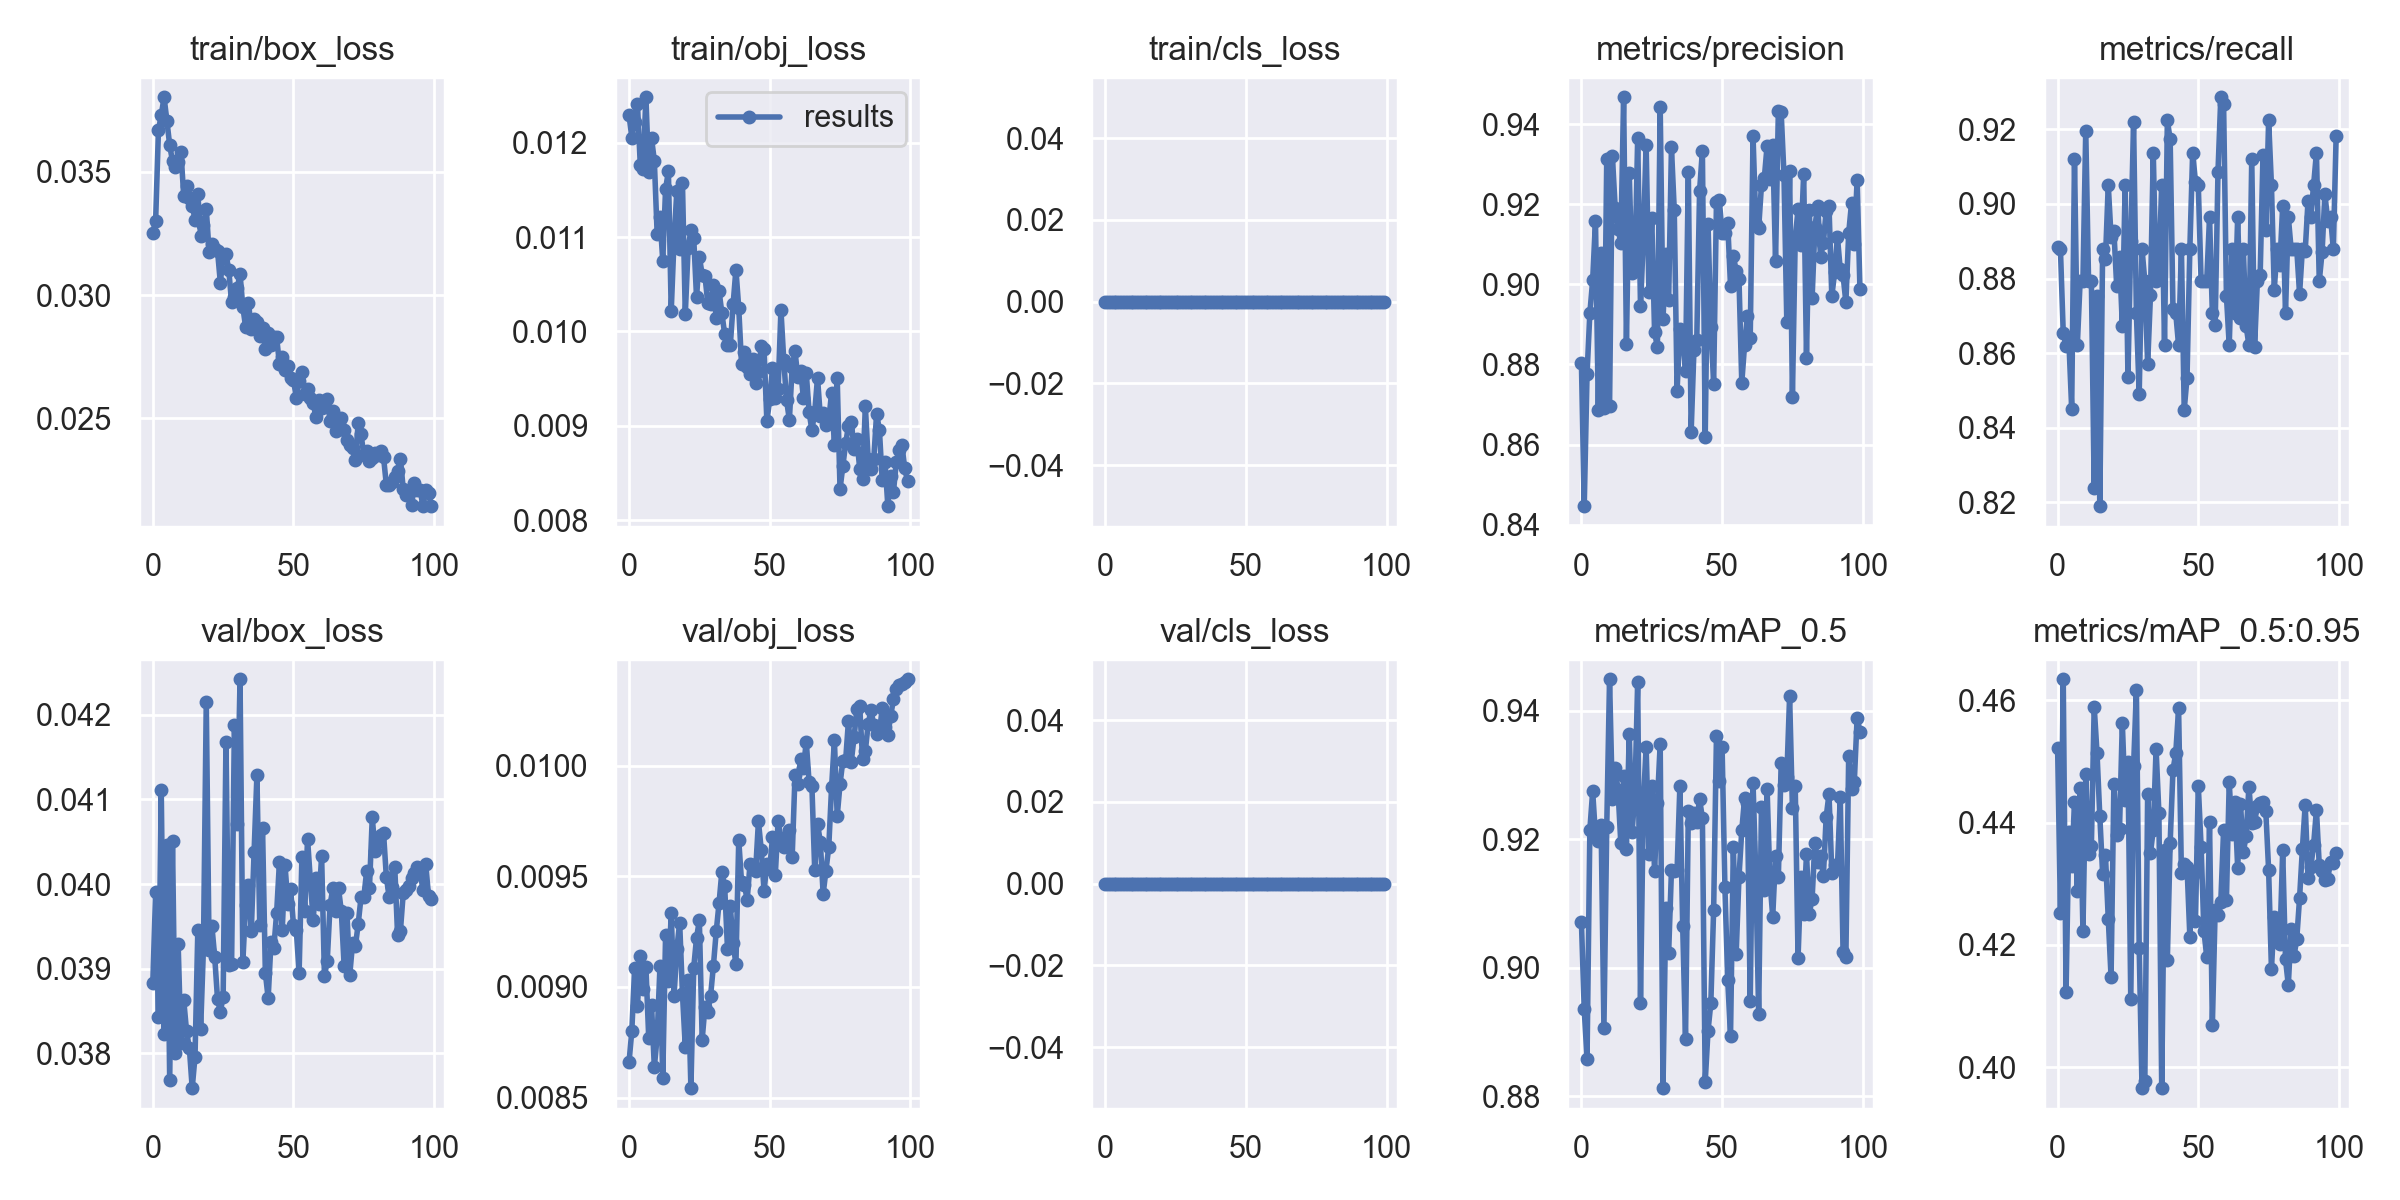

In [238]:
last_run = glob.glob(f"runs_pool/fine_tune*")[-1]
display.Image(f"{last_run}/results.png")

# Inference !

In [ ]:
!python detect.py --weights runs_pool/fine_tune5/weights/best.pt --conf 0.6 --source ../datasets/Pool_data/images/test --project runs_pool --name detect_test --augment --line=3
clear_output()

In [243]:
last_run = glob.glob(f"runs_pool/detect_test*")[-1]

'runs_pool\\detect_test2'

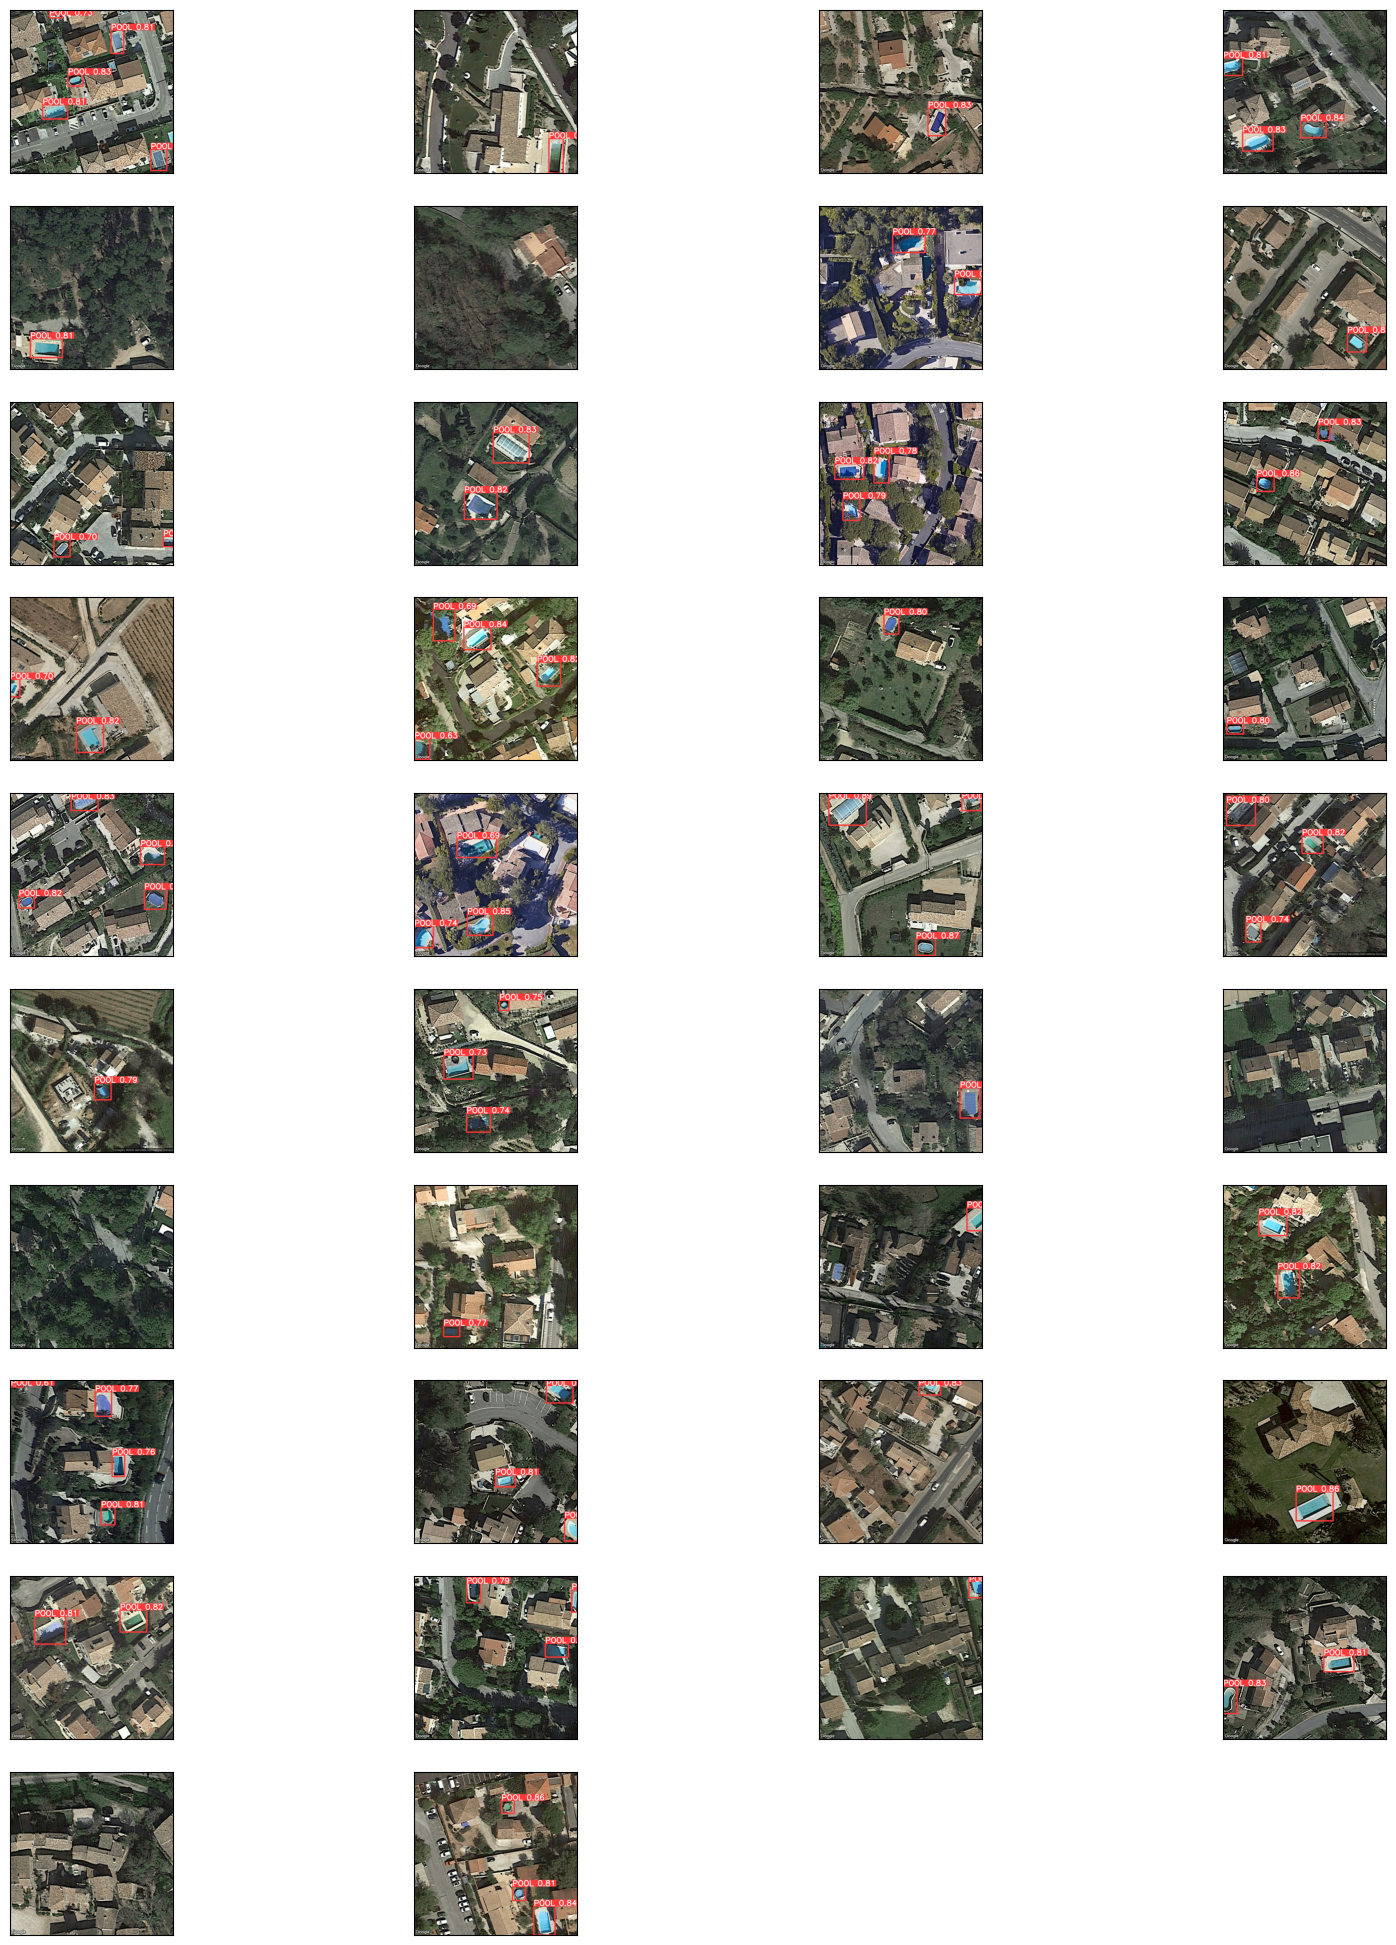

In [247]:
detect_path = glob.glob(f"runs_pool/detect_test*")[-1]
images = []
for img_path in glob.glob(detect_path + '/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,25))
columns = 4
for i, image in enumerate(images):
    plt.subplot((int(len(images) / columns + 1)), columns, i + 1)
    plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    plt.imshow(image)